In [1]:
import matplotlib
%matplotlib inline
from matplotlib.colors import LogNorm
import yt
from yt.analysis_modules.sunyaev_zeldovich.api import SZProjection
# From http://yt-project.org/doc/analyzing/analysis_modules/sunyaev_zeldovich.html

Below, we load in the fits formatted data cubes for temperature, density, and velocity into 256^3 numpy arrays, then create a datastructure with the names and units of the data.

In [6]:
from SZmaps.IO import get_fits_data as gf
reload(gf)
datastructure = gf.create_yt_datastruc_from_cubes('/home/babyostrich/data/L500_fits/','1.0005',1, 6)
dd = datastructure.all_data()

yt : [INFO     ] 2017-06-27 09:33:37,816 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-27 09:33:37,817 Parameters: domain_dimensions         = [ 256.  256.  256.]
yt : [INFO     ] 2017-06-27 09:33:37,818 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-06-27 09:33:37,819 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-06-27 09:33:37,820 Parameters: cosmological_simulation   = 0.0


As a test, let us render slices of each field

yt : [INFO     ] 2017-06-27 09:33:40,176 xlim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 09:33:40,177 ylim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 09:33:40,179 xlim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 09:33:40,180 ylim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 09:33:40,182 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



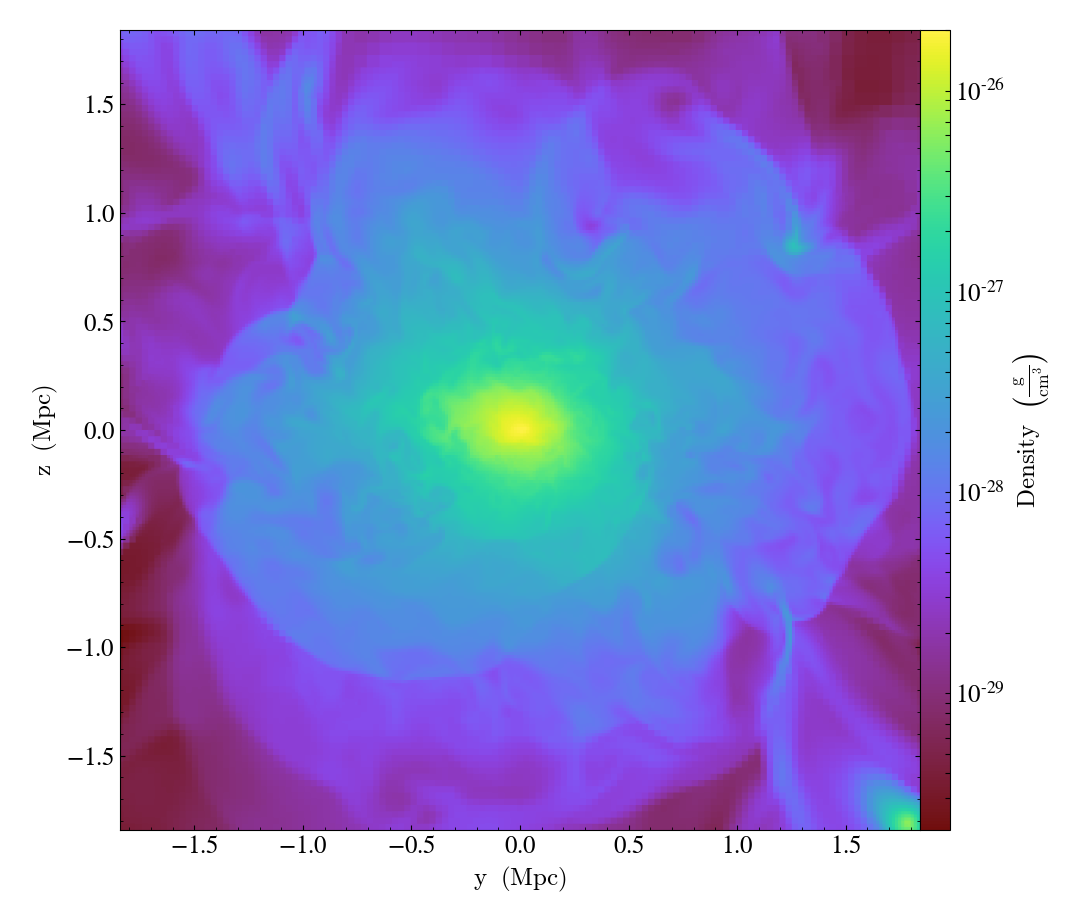

In [7]:
yt.SlicePlot(datastructure, 'x', ['density'])

yt : [INFO     ] 2017-06-27 09:33:44,919 xlim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 09:33:44,920 ylim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 09:33:44,922 xlim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 09:33:44,923 ylim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 09:33:44,924 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



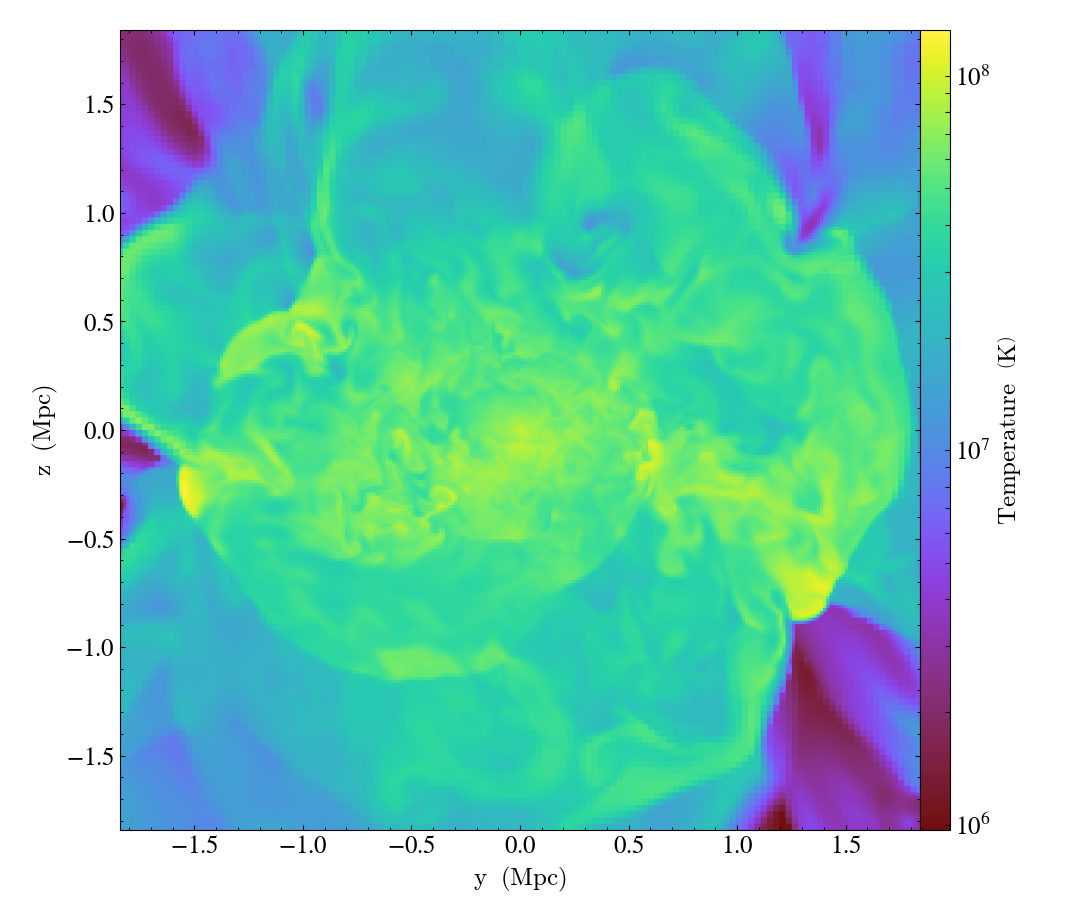

In [8]:
yt.SlicePlot(datastructure, 'x', ['temperature'])

yt : [INFO     ] 2017-06-27 09:33:50,598 xlim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 09:33:50,599 ylim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 09:33:50,603 xlim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 09:33:50,603 ylim = 0.000000 1.000000
yt : [INFO     ] 2017-06-27 09:33:50,607 Making a fixed resolution buffer of (('gas', 'velocity_y')) 800 by 800
yt : [WARNING  ] 2017-06-27 09:33:50,673 Plot image for field ('gas', 'velocity_y') has both positive and negative values. Min = -148014085.721141, Max = 156625009.471575.
yt : [WARNING  ] 2017-06-27 09:33:50,674 Switching to symlog colorbar scaling unless linear scaling is specified later



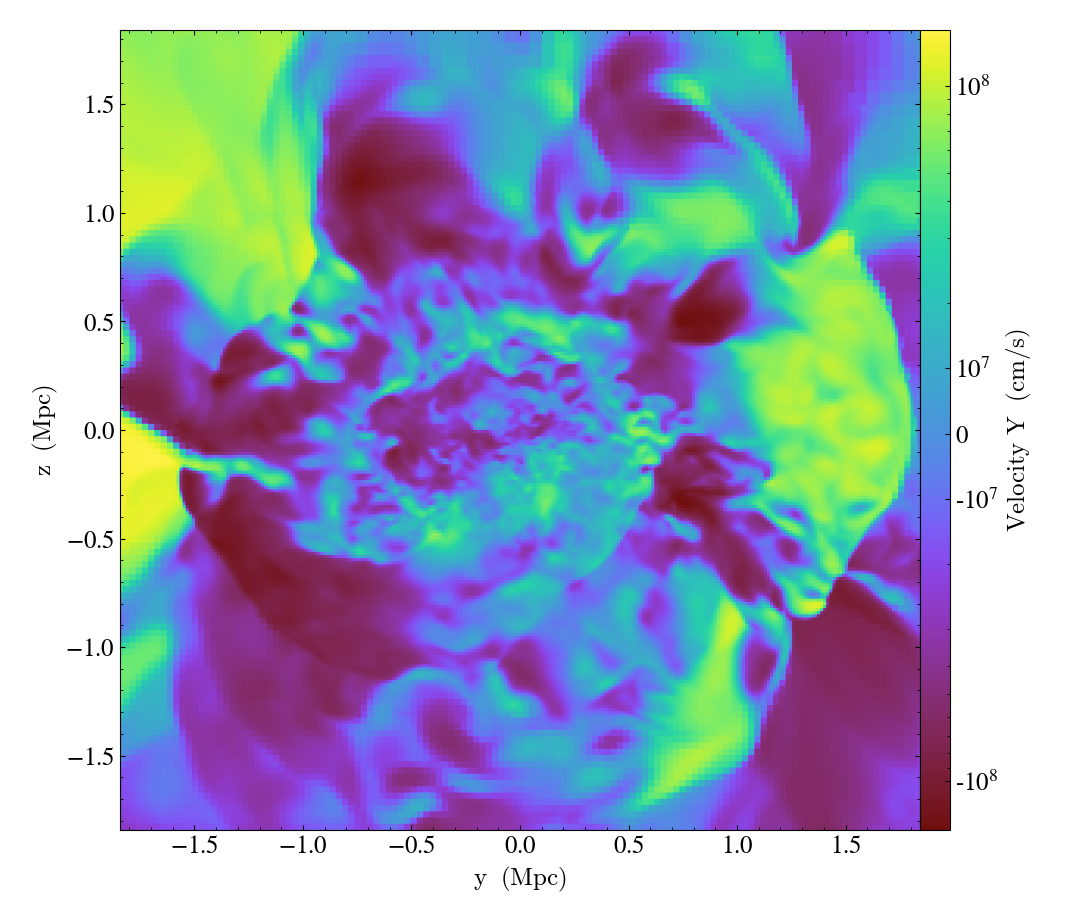

In [9]:
yt.SlicePlot(datastructure, 'x', ['velocity_y'])

Now, we can use the temperature, density, and velocities to initialize a yt SZProjection object.  

In [10]:
freqs = [95.,150.,220.]
szprj = SZProjection(datastructure, freqs)

The following step takes ~2-3 minutes to calculate the projection.  We therefore save the calculation in a fits file, which contains a fits image of the SZ signal at each of the specified frequencies, a TeSZ projection, and a Tau projection.

In [11]:
szprj.on_axis('z')

yt : [INFO     ] 2017-06-27 09:33:58,266 Projection completed
yt : [INFO     ] 2017-06-27 09:33:58,268 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2017-06-27 09:33:58,286 Making a fixed resolution buffer of (t_sz) 800 by 800
yt : [INFO     ] 2017-06-27 09:33:59,469 Projection completed
yt : [INFO     ] 2017-06-27 09:33:59,495 Making a fixed resolution buffer of (beta_par) 800 by 800
yt : [INFO     ] 2017-06-27 09:34:01,362 Projection completed
yt : [INFO     ] 2017-06-27 09:34:01,384 Making a fixed resolution buffer of (t_squared) 800 by 800
yt : [INFO     ] 2017-06-27 09:34:02,690 Projection completed
Computing SZ signal.: 100%|██████████| 640000/640000 [02:02<00:00, 5203.36it/s]


In [13]:
szprj.write_fits('/home/babyostrich/data/L500_fits/szprjz_a1.0005_CL1_N256_Lv6.fits',clobber=True)

yt : [INFO     ] 2017-06-27 09:36:13,772 Making a FITS image of field 150_GHz
yt : [INFO     ] 2017-06-27 09:36:13,776 Making a FITS image of field 220_GHz
yt : [INFO     ] 2017-06-27 09:36:13,779 Making a FITS image of field 95_GHz
yt : [INFO     ] 2017-06-27 09:36:13,783 Making a FITS image of field TeSZ
yt : [INFO     ] 2017-06-27 09:36:13,786 Making a FITS image of field Tau


In [14]:
from astropy.io import fits
sz_z = fits.open('/home/babyostrich/data/L500_fits/szprjz_a1.0005_CL1_N256_Lv6.fits')

In [15]:
sz_z.info()

Filename: /home/babyostrich/data/L500_fits/szprjz_a1.0005_CL1_N256_Lv6.fits
No.    Name         Type      Cards   Dimensions   Format
  0  150_GHZ     PrimaryHDU      21   (800, 800)   float64   
  1  220_GHZ     ImageHDU        22   (800, 800)   float64   
  2  95_GHZ      ImageHDU        22   (800, 800)   float64   
  3  TESZ        ImageHDU        22   (800, 800)   float64   
  4  TAU         ImageHDU        22   (800, 800)   float64   


We can also directly access each of the projections from the SZProjection object as dictionary items.  NOTE: I'm not sure what the units on all of these are.  TeSZ looks like it could be log temperature in Kelvin.

In [133]:
szprj.keys()

['150_GHz', '220_GHz', '95_GHz', 'TeSZ', 'Tau']

In [16]:
def render_labeled(arr, label=None, label_loc=(0,0),norm=None) :
    plt.imshow(arr,norm=norm)
    plt.annotate(label, label_loc, fontsize='xx-large', color='white')
    plt.colorbar()

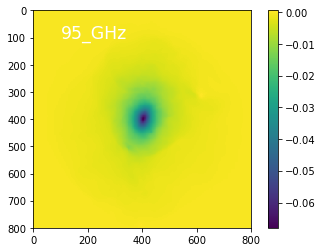

In [24]:
render_labeled(szprj['95_GHz'],label='95_GHz',label_loc=(100,100))

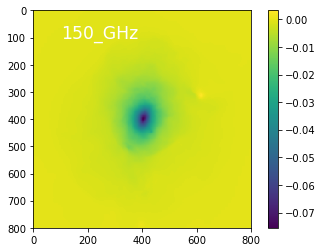

In [22]:
render_labeled(szprj['150_GHz'],label='150_GHz',label_loc=(100,100))

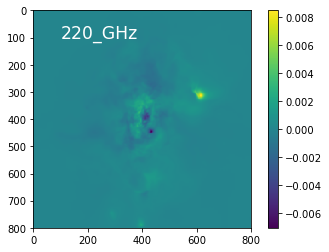

In [23]:
render_labeled(szprj['220_GHz'],label='220_GHz',label_loc=(100,100))

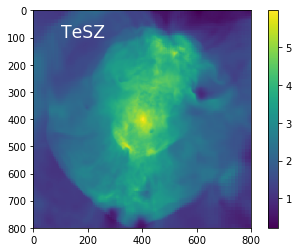

In [20]:
render_labeled(szprj['TeSZ'],label='TeSZ',label_loc=(100,100))

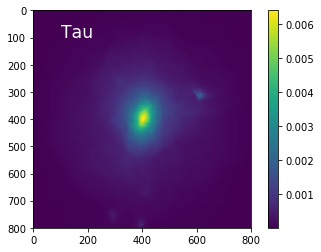

In [21]:
render_labeled(szprj['Tau'],label='Tau',label_loc=(100,100))

To do: 

**(1) Figure out the units on the SZ signals!**

**(2) Figure out how one might stack just two of these.**

**(3) How do I get an integrated signal out?   (How do I define units of area?) **